In [1]:
import os
import sys
p = '..'
while not os.path.isdir(p + '/notebooks'):
    p += '/..'
sys.path.append(p) # for import src

import os
import cloudpickle
import lzma
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_predict
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import lightgbm as lgb
import talib
import joblib
import warnings

from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import r2_score, make_scorer
from sklearn.linear_model import Ridge, RidgeCV
from scipy.stats import spearmanr
from sklearn.ensemble import BaggingRegressor, VotingRegressor, StackingRegressor, IsolationForest
from sklearn.base import clone
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_selection import SelectPercentile, mutual_info_regression
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.covariance import EllipticEnvelope
from sklearn.manifold import LocallyLinearEmbedding, Isomap, SpectralEmbedding
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering, FeatureAgglomeration

import src
from src.ml_utils import (
    fetch_ohlcv, 
    visualize_result, 
    normalize_position, 
    calc_position_cv2,
    get_feature_columns,
    get_symbols,
    unbiased_rank,
    ewm_finite,
    calc_double_sharpe,
)
from src.data_fetcher import DataFetcher
cloudpickle.register_pickle_by_value(src) # for model portability

os.environ["USE_JOBLIB_MEMORY"] = "1"

def get_joblib_memory():
    if os.getenv('USE_JOBLIB_MEMORY'):
        return joblib.Memory('/tmp/alphapool_joblib_memory', verbose=0)
    else:
        return joblib.Memory(None, verbose=0)

def my_cache(func):
    def func2(*args, **kwargs):
        mem = get_joblib_memory()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            return mem.cache(func)(*args, **kwargs)
    return func2

@my_cache
def fit_model_cached(model, *args, **kwargs):
    model = clone(model)
    model.fit(*args, **kwargs)
    return model

# unbiased_rank = my_cache(unbiased_rank)
# cross_val_predict = my_cache(cross_val_predict)
    
model_name = '20221224_beta_one'

In [2]:
# symbols = os.getenv('ALPHAPOOL_SYMBOLS').split(',') # 売買代金が多く、古いもの
# symbols += 'DOGE,SFP,DYDX,AXS,CHZ,TRX,MASK,ETC,LTC,1000SHIB,C98,SAND,SUSHI,NEAR,FIL'.split(',')
# symbols += 'SFP,DYDX,AXS,TRX,MASK,ETC,LTC,1000SHIB,C98,SAND,SUSHI,NEAR,FIL'.split(',')
# symbols = ['ADA', 'ATOM', 'BTC', 'DOT', 'ETH', 'LINK', 'MATIC', 'XRP', 'ETC', 'LTC'] # binance, bybit, okex
# symbols = ['ADA', 'ATOM', 'BTC', 'DOT', 'ETH', 'LINK', 'MATIC', 'XRP', 'ETC'] # binance, bybit, okex
symbols = ['ADA', 'ATOM', 'BTC', 'DOT', 'ETH', 'LINK', 'MATIC', 'XRP', 'ETC', 'AVAX'] # binance, bybit, okex
# symbols = ['ADA', 'ATOM', 'BNB', 'BTC', 'DOT', 'ETH', 'LINK', 'MATIC', 'XRP', 'ETC', 'LTC'] # binance, bybit
# symbols = ['ADA', 'ATOM', 'BNB', 'BTC', 'DOT', 'ETH', 'LINK', 'MATIC', 'XRP'] # binance, bybit

provider_configs = [
    {
        'provider': 'bigquery',
        'options': {
            'table': 'binance_ohlcv',
            'symbols': ['{}USDT'.format(x) for x in symbols],
        }
    },
    {
        'provider': 'bigquery',
        'options': {
            'table': 'binance_ohlcv_spot',
            'symbols': ['{}USDT'.format(x) for x in symbols],
        }
    },
]

dfs = DataFetcher(memory=get_joblib_memory()).fetch(
    provider_configs=provider_configs, 
    min_timestamp=None,
)

for df in dfs:
    display(df)

def merge_data(dfs):
    def func1(df):
        df['symbol'] = df['symbol'].str.replace('USDT', '')
        df = df.set_index(['timestamp', 'symbol']).sort_index()
        df = df.loc[~df.index.duplicated()]
        return df
    
    df = func1(dfs[0])
    df_spot = func1(dfs[1])
    # df_bb = func1(dfs[2])
    df = df.join(df_spot, rsuffix='_spot')
    # df = df.join(df_bb, rsuffix='_bb')
    return df

df = merge_data(dfs)

def merge_kraken_data(df):
    symbols = list(df.index.get_level_values('symbol').unique())
    
    train_provider_configs = [
        {
            'provider': 'bigquery',
            'options': {
                'table': 'kraken_historical_ohlcvt',
                'symbols': symbols,
            }
        },
    ]

    dfs = DataFetcher(memory=get_joblib_memory()).fetch(
        provider_configs=train_provider_configs, 
        min_timestamp=None,
    )
    df_kraken = dfs[0].set_index(['timestamp', 'symbol'])

    df = df.copy()
    df['extended'] = False
    df = pd.concat([df, df_kraken])
    df['extended'] = df['extended'].fillna(True)
    df = df[['op', 'hi', 'lo', 'cl', 'volume', 'twap_5m', 'extended']]
    df = df.loc[~df.index.duplicated()]
    df = df.sort_index()
    return df.copy()

# df = merge_kraken_data(df)

df = df.dropna()
df.to_pickle('/tmp/df_binance_ohlcv_with_spot.pkl')
display(df)

,timestamp,symbol,op,hi,lo,cl,volume,amount,trades,buy_volume,...,twap,twap_5m,cl_std,cl_diff_std,hi_twap,lo_twap,hi_op_max,lo_op_min,ln_hi_lo_mean,ln_hi_lo_sqr_mean
0,2020-07-21 10:00:00+00:00,ADAUSDT,0.12331,0.12487,0.12280,0.12405,54507440.0,6.747082e+06,18144.0,30443717.0,...,0.123603,0.123584,0.000408,0.000165,0.123722,0.123462,0.000134,-0.000126,0.002104,0.000006
1,2020-07-31 23:00:00+00:00,ADAUSDT,0.13995,0.14048,0.13894,0.13905,18505000.0,2.586235e+06,4973.0,7431129.0,...,0.139770,0.139732,0.000434,0.000119,0.139873,0.139697,0.000084,-0.000091,0.001256,0.000002
2,2020-07-15 18:00:00+00:00,ADAUSDT,0.13001,0.13058,0.12889,0.12959,16873277.0,2.191102e+06,5034.0,8229229.0,...,0.130034,0.130029,0.000317,0.000129,0.130132,0.129919,0.000095,-0.000118,0.001637,0.000003
3,2020-07-28 22:00:00+00:00,ADAUSDT,0.14834,0.15162,0.14800,0.14943,72027789.0,1.078046e+07,28796.0,37188286.0,...,0.149381,0.149502,0.000699,0.000378,0.149634,0.149096,0.000266,-0.000272,0.003598,0.000018
4,2020-07-25 05:00:00+00:00,ADAUSDT,0.13002,0.13093,0.12946,0.13040,42752754.0,5.565174e+06,8777.0,21061815.0,...,0.130098,0.130105,0.000336,0.000140,0.130219,0.130007,0.000120,-0.000093,0.001634,0.000004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243694,2021-09-09 23:00:00+00:00,MATICUSDT,1.37300,1.38410,1.35780,1.36950,8593286.0,1.177633e+07,19604.0,3871446.0,...,1.372892,1.373392,0.006475,0.002189,1.374342,1.371388,0.001390,-0.001563,0.002152,0.000005
243695,2021-09-08 03:00:00+00:00,MATICUSDT,1.36670,1.38140,1.32230,1.32740,22396230.0,3.011624e+07,40085.0,11341226.0,...,1.345375,1.341883,0.017437,0.004174,1.349042,1.342488,0.003038,-0.003515,0.004870,0.000028
243696,2021-09-15 23:00:00+00:00,MATICUSDT,1.39730,1.42130,1.39710,1.41660,16490961.0,2.325462e+07,39626.0,8249301.0,...,1.409358,1.409433,0.006002,0.002879,1.411028,1.407437,0.002015,-0.001577,0.002547,0.000009
243697,2021-09-16 12:00:00+00:00,MATICUSDT,1.46080,1.47960,1.44760,1.46590,17207194.0,2.521050e+07,39363.0,8061897.0,...,1.465312,1.465517,0.006529,0.002762,1.467112,1.463237,0.001888,-0.001987,0.002646,0.000008


,timestamp,symbol,op,hi,lo,cl,volume,amount,trades,buy_volume,...,twap,twap_5m,cl_std,cl_diff_std,hi_twap,lo_twap,hi_op_max,lo_op_min,ln_hi_lo_mean,ln_hi_lo_sqr_mean
0,2021-04-30 19:00:00+00:00,ADAUSDT,1.35520,1.35990,1.35150,1.35740,7561543.58,1.025143e+07,13356.0,4124158.35,...,1.355917,1.355808,0.001894,0.001136,1.356732,1.355068,0.000848,-0.000815,0.001227,0.000002
1,2021-04-23 03:00:00+00:00,ADAUSDT,1.03622,1.09520,1.02296,1.09456,73601482.40,7.817627e+07,99098.0,37640849.10,...,1.064433,1.066878,0.013125,0.006556,1.068533,1.058984,0.005054,-0.004494,0.009004,0.000108
2,2021-04-20 12:00:00+00:00,ADAUSDT,1.21459,1.21532,1.19433,1.20006,12347291.50,1.485180e+07,24222.0,5723130.80,...,1.202335,1.201461,0.003718,0.001981,1.204009,1.201199,0.001431,-0.001379,0.002337,0.000006
3,2021-04-25 08:00:00+00:00,ADAUSDT,1.09773,1.12911,1.09713,1.12060,4096012.26,4.588942e+06,6572.0,1922635.45,...,1.121333,1.121867,0.003616,0.004244,1.123438,1.117609,0.003689,-0.002140,0.005216,0.000044
4,2021-05-05 16:00:00+00:00,ADAUSDT,1.37670,1.43800,1.37000,1.42440,54598319.58,7.709847e+07,105878.0,29825843.87,...,1.407853,1.410058,0.017936,0.003905,1.410222,1.404737,0.003133,-0.002352,0.003889,0.000019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354172,2021-03-14 00:00:00+00:00,MATICUSDT,0.42526,0.44049,0.41919,0.41998,20406692.10,8.763007e+06,14534.0,10898280.60,...,0.425839,0.426234,0.005091,0.001541,0.426914,0.424879,0.000987,-0.001048,0.004748,0.000036
354173,2021-03-02 01:00:00+00:00,MATICUSDT,0.23407,0.24315,0.23300,0.24311,15974411.80,3.788843e+06,6843.0,8026210.90,...,0.236953,0.237313,0.002980,0.000486,0.237295,0.236586,0.000458,-0.000251,0.002994,0.000012
354174,2021-03-09 23:00:00+00:00,MATICUSDT,0.29654,0.30292,0.28799,0.29900,39529687.80,1.170508e+07,17533.0,21256748.20,...,0.295281,0.295057,0.003624,0.001208,0.296114,0.294345,0.000846,-0.000923,0.005985,0.000045
354175,2021-02-25 01:00:00+00:00,MATICUSDT,0.16908,0.17300,0.16567,0.17252,42983032.20,7.292413e+06,12808.0,22236521.60,...,0.169144,0.169464,0.001639,0.000906,0.169746,0.168280,0.000672,-0.000793,0.008671,0.000084


op          hi          lo  \
timestamp                 symbol                                       
2019-09-08 17:00:00+00:00 BTC     10000.0000  10000.0000  10000.0000   
2019-09-08 18:00:00+00:00 BTC     10000.0000  10000.0000  10000.0000   
2019-09-08 19:00:00+00:00 BTC     10000.0000  10357.5300  10000.0000   
2019-09-08 20:00:00+00:00 BTC     10340.1200  10368.6400  10334.5400   
2019-09-08 21:00:00+00:00 BTC     10351.4200  10391.9000  10324.7700   
...                                      ...         ...         ...   
2022-12-26 13:00:00+00:00 ADA         0.2614      0.2622      0.2606   
                          BTC     16849.9000  16850.6000  16821.0000   
                          ETH      1218.9700   1219.1800   1210.0000   
                          LINK        5.9840      5.9900      5.9660   
                          MATIC       0.8020      0.8021      0.7984   

                                          cl        volume        amount  \
timestamp                 symbol                                           
2019-09-08 17:00:00+00:00 BTC     10000.0000  2.000000e-03  2.000000e+01   
2019-09-08 18:00:00+00:00 BTC     10000.0000  0.000000e+00  0.000000e+00   
2019-09-08 19:00:00+00:00 BTC     10340.1200  4.716590e+02  4.879792e+06   
2019-09-08 20:00:00+00:00 BTC     10351.4200  5.832710e+02  6.037733e+06   
2019-09-08 21:00:00+00:00 BTC     10391.9000  6.897590e+02  7.136799e+06   
...                                      ...           ...           ...   
2022-12-26 13:00:00+00:00 ADA         0.2616  1.674549e+07  4.377750e+06   
                          BTC     16829.9000  6.656667e+03  1.120736e+08   
                          ETH      1215.3700  1.775501e+05  2.158366e+08   
                          LINK        5.9740  7.966123e+05  4.761113e+06   
                          MATIC       0.7997  7.568388e+06  6.057820e+06   

                                   trades   buy_volume    buy_amount  \
timestamp                 symbol                                       
2019-09-08 17:00:00+00:00 BTC         2.0        0.001  1.000000e+01   
2019-09-08 18:00:00+00:00 BTC         0.0        0.000  0.000000e+00   
2019-09-08 19:00:00+00:00 BTC       562.0        0.000  0.000000e+00   
2019-09-08 20:00:00+00:00 BTC       731.0        0.034  3.519712e+02   
2019-09-08 21:00:00+00:00 BTC       827.0        0.004  4.138500e+01   
...                                   ...          ...           ...   
2022-12-26 13:00:00+00:00 ADA      8211.0  7216502.000  1.886923e+06   
                          BTC     32538.0     3094.244  5.209322e+07   
                          ETH     87842.0    78494.654  9.543113e+07   
                          LINK     8804.0   371118.490  2.218104e+06   
                          MATIC   10394.0  3350727.000  2.682281e+06   

                                          twap  ...     twap_spot  \
timestamp                 symbol                ...                 
2019-09-08 17:00:00+00:00 BTC     10000.000000  ...  10376.195333   
2019-09-08 18:00:00+00:00 BTC     10000.000000  ...  10361.588167   
2019-09-08 19:00:00+00:00 BTC     10275.480000  ...  10347.438500   
2019-09-08 20:00:00+00:00 BTC     10350.826833  ...  10353.787833   
2019-09-08 21:00:00+00:00 BTC     10347.270500  ...  10351.302333   
...                                        ...  ...           ...   
2022-12-26 13:00:00+00:00 ADA         0.261503  ...      0.261658   
                          BTC     16838.706667  ...  16847.207333   
                          ETH      1216.800000  ...   1217.417333   
                          LINK        5.977900  ...      5.981500   
                          MATIC       0.800667  ...      0.801030   

                                  twap_5m_spot  cl_std_spot  cl_diff_std_spot  \
timestamp                 symbol                                                
2019-09-08 17:00:00+00:00 BTC     10377.110000    11.556934          6.601724   
2019-09-08 18:00:00+00:00 BTC     1036

In [3]:
# based on 20220910_eda

import numba
from pandas.api.types import is_float_dtype
from joblib import Parallel, delayed

def signed_rsi_sma(x, timeperiod=14):
    v = x.diff(1).fillna(0)
    return (v.rolling(timeperiod, 1).sum() / (1e-37 + v.abs().rolling(timeperiod, 1).sum())).clip(-1, 1)

def uniform_rank(x):
    return unbiased_rank(x)
    # count = x.transform("count")
    # rank = x.rank()
    # return (rank - 0.5) / count

# @my_cache
def beta_mean(ser):
    # broadcast btc value
    # idx = df.index.to_frame()
    # idx['symbol'] = 'BTC'
    # idx = pd.MultiIndex.from_frame(idx)
    # return pd.Series(df.loc[idx, col].values, index=df.index)
    return ser.groupby('timestamp').transform('mean')

def calc_features(df):
    df_features = do_calc_features(df[[
        'op', 'hi', 'lo', 'cl', 'volume'
    ]])
    return pd.concat([df, df_features[get_feature_columns(df_features)]], axis=1)

@my_cache
def do_calc_features(df):
    df = df.copy()
    
    dfs = []
    for symbol, df_symbol in df.groupby('symbol'):
        dfs.append(delayed(calc_features_single)(df_symbol))
        # dfs.append(calc_features_single(df_symbol))
    dfs = Parallel(n_jobs=-1)(dfs)
    df = pd.concat(dfs).sort_index()

    beta_window = 24 * 30
    # beta_window = 24 * 7

    # df['ln_cl_diff_mean'] = df.groupby('timestamp')['ln_cl_diff'].transform('mean')
    # df['ln_cl_diff_mean'] = beta_mean(df, 'ln_cl_diff')
    
    # wrong
    # df['beta'] = df.groupby('symbol')['ln_cl_diff'].transform(lambda x: x.rolling(beta_window, 1).corr(df.loc[x.index, 'ln_cl_diff_mean'])).fillna(0).clip(0.1, 2.0)

    # df['beta'] = (
    #     (df['ln_cl_diff'] * df['ln_cl_diff_mean']).groupby('symbol').transform(lambda x: x.rolling(beta_window, 1).mean())
    #     / (df['ln_cl_diff_mean'] ** 2).groupby('symbol').transform(lambda x: x.rolling(beta_window, 1).mean())
    # ).fillna(0).clip(0.1, 2.0)
    df['beta'] = 1.0
    
    dfs = [
        df,
        # df.drop(columns=get_feature_columns(df)),
    ]
        
    dfs_parallel = []
    def func_parallel1(col):
        feature_mean = beta_mean(df[col])
        return [
            (2 * uniform_rank(df.groupby('timestamp')[col]) - 1).rename(col + '_symbolrank'),
            (df[col] - df['beta'] * feature_mean).rename(col + '_symbolbeta'),
        ]
    for col in get_feature_columns(df):
        dfs_parallel.append(delayed(func_parallel1)(col))
    for res in Parallel(n_jobs=-1)(dfs_parallel):
        dfs += res
    
    df = pd.concat(dfs, axis=1)
    
    df = df[sorted([x for x in df.columns if is_float_dtype(df.dtypes[x])])].copy().astype('float32')

    return df

def calc_features_single(df):
    df = df.copy()

    high = df['hi']
    low = df['lo']
    close = df['cl']
    volume = df['volume']
    df['ln_cl'] = np.log(df['cl'])
    df['ln_hi'] = np.log(df['hi'])
    df['ln_lo'] = np.log(df['lo'])
    df['ln_hilo'] = 0.5 * (df['ln_hi'] + df['ln_lo'])
    df['ln_cl_diff'] = df['ln_cl'].diff(1).fillna(0)
    
    def adx(t):
        return (talib.ADX(high, low, close, timeperiod=t) / 100).fillna(0)

    def adxr(t):
        return (talib.ADXR(high, low, close, timeperiod=t) / 100).fillna(0)

    def rsi(t):
        return signed_rsi_sma(close, timeperiod=t).fillna(0)

    def rsi_hilo(t):
        return signed_rsi_sma(0.5 * (high + low), timeperiod=t).fillna(0)

    def rsi_volume(t):
        return signed_rsi_sma(volume, timeperiod=t).fillna(0)

    def aroon_down(t):
        return (talib.AROON(high, low, timeperiod=t)[0] / 100).fillna(0)
    def aroon_up(t):
        return (talib.AROON(high, low, timeperiod=t)[1] / 100).fillna(0)

    def aroonosc(t):
        return (talib.AROONOSC(high, low, timeperiod=t) / 100).fillna(0)

    def cci(t):
        return talib.CCI(high, low, close, timeperiod=t).fillna(0)

    def cmo(t):
        return talib.CMO(close, timeperiod=t).fillna(0)

    def dx(t):
        return (talib.DX(high, low, close, timeperiod=t) / 100).fillna(0)

    def mfi(t):
        return (talib.MFI(high, low, close, volume, timeperiod=t) / 50 - 1).fillna(0)

    def trix(t):
        return talib.TRIX(close, timeperiod=t).fillna(0)

    def atr(t):
        return talib.ATR(high, low, close, timeperiod=t).fillna(0)

    def natr(t):
        return talib.NATR(high, low, close, timeperiod=t).fillna(0)

    def ma_kairi(t):
        return df['ln_cl'] - df['ln_cl'].rolling(t, 1).mean()

    def mid_kairi(t):
        return df['ln_cl'] - 0.5 * (df['ln_hi'].rolling(t, 1).max() + df['ln_lo'].rolling(t, 1).min())

    def median_kairi(t):
        return df['ln_cl'] - df['ln_cl'].rolling(t, 1).median()

    def zscore(t):
        return ((df['ln_cl'] - df['ln_cl'].rolling(t, 1).mean()) / df['ln_cl'].rolling(t, 1).std()).fillna(0)

    def volume_corr(t):
        return df['volume'].rolling(t, 1).corr(df['cl']).fillna(0).clip(-1, 1)

    def range_pos_general(x, t):
        hi = x.rolling(t, 1).max()
        lo = x.rolling(t, 1).min()
        return (2 * (x - lo) / (hi - lo) - 1).fillna(0)

    def range_pos(t):
        hi = df['ln_hi'].rolling(t, 1).max()
        lo = df['ln_lo'].rolling(t, 1).min()
        return (2 * (df['ln_cl'] - lo) / (hi - lo) - 1).fillna(0)

    def range_pos_rank(t):
        return skew_ratio(df['ln_cl'], df['ln_cl'], np.ones(df.shape[0]), t)

    def obv_rsi(t):
        return signed_rsi_sma(talib.OBV(close, volume), timeperiod=t).fillna(0)

    def ad_rsi(t):
        return signed_rsi_sma(talib.AD(high, low, close, volume), timeperiod=t).fillna(0)
    
    def bwmfi_rsi(t):
        bwmfi = (df['hi'] - df['lo']) / (1 + df['volume'])
        return signed_rsi_sma(bwmfi, timeperiod=t).fillna(0)

    def macdsignal(t):
        return talib.MACDEXT(df['ln_cl'], fastperiod=int(max(2, t / 26.0 * 12)), slowperiod=max(2, t), signalperiod=int(max(2, t / 26.0 * 9)))[1].fillna(0)

    def stoch(t):
        k, d = talib.STOCH(high, low, close, fastk_period=t, slowk_period=int(max(2, t / 5.0 * 3)), slowd_period=int(max(2, t / 5.0 * 3)))
        return (k / 50 - 1).fillna(0), (d / 50 - 1).fillna(0)

    def stochf(t):
        k, d = talib.STOCHF(high, low, close, fastk_period=t, fastd_period=int(max(2, t / 5.0 * 3)))
        return (k / 50 - 1).fillna(0), (d / 50 - 1).fillna(0)

    def stochrsi(t):
        k, d = talib.STOCHRSI(close, timeperiod=t, fastk_period=int(max(2, t / 14.0 * 5)), fastd_period=int(max(2, t / 14.0 * 3)))
        return (k / 50 - 1).fillna(0), (d / 50 - 1).fillna(0)

    def ultosc(t):
        return (talib.ULTOSC(high, low, close, timeperiod1=max(2, t // 4), timeperiod2=max(2, t // 2), timeperiod3=t) / 50 - 1).fillna(0)

    def volume_ratio(t):
        return ((np.sign(close.diff(1).fillna(0)) * volume).rolling(t, 1).sum() / volume.rolling(t, 1).sum()).fillna(0).clip(-1, 1)

    @numba.njit
    def do_skew_ratio(ref_price, price, weight, t):
        n = ref_price.shape[0]
        y = ref_price.copy()
        for i in range(n):
            price_slice = price[max(0, i - t + 1):i + 1]
            weight_slice = weight[max(0, i - t + 1):i + 1]
            y[i] = np.sum(np.sign(price_slice - ref_price[i]) * weight_slice) / (1e-37 + np.sum(weight_slice))
        return y
    
    def skew_ratio(ref_price, price, weight, t):
        return pd.Series(do_skew_ratio(ref_price.values, price.values, to_numpy(weight), t), index=ref_price.index).fillna(0)
    
    def to_numpy(x):
        if hasattr(x, 'values'):
            return x.values
        else:
            return x

    dfs = [
        df,
    ]

    # for t in [24]:
    # for t_center in [2, 4, 6, 12, 24]:
    # for t_center in [4, 6, 12, 24, 36, 48, 72, 96]:
    for t_center in [6, 12, 24, 48, 96]:
    # for t_center in [3, 6, 8, 12, 18, 24, 36, 48, 72, 96]:
    # for t in [2, 4, 8, 16]:
    # for t in [2, 4, 8, 16, 32, 64]:
        dfs2 = []
        t_shifts = [0]
        # t_shifts = [-1, 0, 1]
        for t_shift in t_shifts:
            t = t_center + t_shift
            
            feature_mom = df['ln_cl_diff'].rolling(t, 1).mean().fillna(0).rename('feature_mom_{}'.format(t))
            feature_integ_std = df['ln_cl'].rolling(t, 1).std().fillna(0).rename('feature_integ_std_{}'.format(t))
            feature_std = df['ln_cl_diff'].rolling(t, 1).std().fillna(0).rename('feature_std_{}'.format(t))

            feature_stoch_k, feature_stoch_d = stoch(t)
            feature_stoch_k = feature_stoch_k.rename('feature_stoch_k_{}'.format(t))
            feature_stoch_d = feature_stoch_d.rename('feature_stoch_d_{}'.format(t))

            feature_stochf_k, feature_stochf_d = stochf(t)
            feature_stochf_k = feature_stochf_k.rename('feature_stochf_k_{}'.format(t))
            feature_stochf_d = feature_stochf_d.rename('feature_stochf_d_{}'.format(t))

            feature_stochrsi_k, feature_stochrsi_d = stochrsi(t)
            feature_stochrsi_k = feature_stochrsi_k.rename('feature_stochrsi_k_{}'.format(t))
            feature_stochrsi_d = feature_stochrsi_d.rename('feature_stochrsi_d_{}'.format(t))

            feature_rsi = rsi(t).rename('feature_rsi_{}'.format(t))

            ln_hilo_vwap = ((df['ln_hilo'] * df['volume']).rolling(t, 1).sum() / df['volume'].rolling(t, 1).sum()).fillna(0)
        

            dfs2 += [
                adx(t).rename('feature_adx_{}'.format(t)),
                adxr(t).rename('feature_adxr_{}'.format(t)),
                feature_rsi,
                rsi_hilo(t).rename('feature_rsi_hilo_{}'.format(t)),
                rsi_volume(t).rename('feature_rsi_volume_{}'.format(t)),
                aroon_down(t).rename('feature_aroon_down_{}'.format(t)),
                aroon_up(t).rename('feature_aroon_up_{}'.format(t)),
                aroonosc(t).rename('feature_aroonosc_{}'.format(t)),
                # cci(t).rename('feature_cci_{}'.format(t)),
                # cmo(t).rename('feature_cmo_{}'.format(t)),
                dx(t).rename('feature_dx_{}'.format(t)),
                mfi(t).rename('feature_mfi_{}'.format(t)),
                # trix(t).rename('feature_trix_{}'.format(t)),
                # feature_integ_std,
                # feature_std,
                # (feature_std - feature_integ_std).fillna(0).rename('feature_mean_reversion_sub_{}'.format(t)),
                # feature_mom,
                # atr(t).rename('feature_atr_{}'.format(t)),
                # natr(t).rename('feature_natr_{}'.format(t)),
                range_pos_general(natr(t), t).rename('feature_natr_range_pos_{}'.format(t)),
                # ma_kairi(t).rename('feature_ma_kairi_{}'.format(t)),
                # mid_kairi(t).rename('feature_mid_kairi_{}'.format(t)),
                # median_kairi(t).rename('feature_median_kairi_{}'.format(t)),
                # df['ln_cl_diff'].rolling(t, 1).kurt().fillna(0).rename('feature_kurt_{}'.format(t)),
                # df['ln_cl_diff'].rolling(t, 1).skew().fillna(0).rename('feature_skew_{}'.format(t)),
                # df['ln_cl'].rolling(t, 1).kurt().fillna(0).rename('feature_integ_kurt_{}'.format(t)),
                # df['ln_cl'].rolling(t, 1).skew().fillna(0).rename('feature_integ_skew_{}'.format(t)),
                volume_corr(t).rename('feature_volume_corr_{}'.format(t)),
                range_pos(t).rename('feature_range_pos_{}'.format(t)),
                range_pos_rank(t).rename('feature_range_pos_rank_{}'.format(t)),
                # skew_ratio(df['ln_cl'], df['ln_hilo'], df['volume'], t).rename('feature_volume_range_pos_rank_{}'.format(t)), # ???
                obv_rsi(t).rename('feature_obv_rsi_{}'.format(t)),
                ad_rsi(t).rename('feature_ad_rsi_{}'.format(t)),
                # bwmfi_rsi(t).rename('feature_bwmfi_rsi_{}'.format(t)), # seems to be useless
                # macdsignal(t).rename('feature_macdsignal_{}'.format(t)),
                feature_stoch_k,
                feature_stoch_d,
                (0.5 * (feature_stoch_k + feature_stoch_d)).rename('feature_stoch_mean_{}'.format(t)),
                (0.5 * (feature_stoch_k - feature_stoch_d)).rename('feature_stoch_sub_{}'.format(t)),
                feature_stochf_k,
                feature_stochf_d,
                (0.5 * (feature_stochf_k + feature_stochf_d)).rename('feature_stochf_mean_{}'.format(t)),
                (0.5 * (feature_stochf_k - feature_stochf_d)).rename('feature_stochf_sub_{}'.format(t)),
                feature_stochrsi_k,
                feature_stochrsi_d,
                (0.5 * (feature_stochrsi_k + feature_stochrsi_d)).rename('feature_stochrsi_mean_{}'.format(t)),
                (0.5 * (feature_stochrsi_k - feature_stochrsi_d)).rename('feature_stochrsi_sub_{}'.format(t)),
                ultosc(t).rename('feature_ultosc_{}'.format(t)),
                volume_ratio(t).rename('feature_volume_ratio_{}'.format(t)),
                skew_ratio(df['ln_cl'].rolling(t, 1).mean(), df['ln_cl'], np.ones(df.shape[0]), t).rename('feature_skew_ratio_{}'.format(t)),
                # skew_ratio(ln_hilo_vwap, df['ln_hilo'], df['volume'], t).rename('feature_volume_skew_ratio_{}'.format(t)), # ???
                (feature_std / (feature_std + feature_integ_std)).fillna(0).rename('feature_mean_reversion_ratio_{}'.format(t)),
                feature_rsi.rolling(t, 1).std().fillna(0).rename('feature_rsi_integ_std_{}'.format(t)),
                (feature_rsi.diff(1).fillna(0).rolling(t, 1).std() / 2).fillna(0).rename('feature_rsi_std_{}'.format(t)),
                # dimension less but not bounded
                # (feature_std / feature_integ_std).fillna(0).rename('feature_mean_reversion_{}'.format(t)),
                # (feature_mom / feature_std).fillna(0).rename('feature_sharpe_{}'.format(t)),
                # zscore(t).rename('feature_zscore_{}'.format(t)),
                # feature_rsi.diff(1).fillna(0).rolling(t, 1).kurt().fillna(0).rename('feature_rsi_kurt_{}'.format(t)),
                # feature_rsi.diff(1).fillna(0).rolling(t, 1).skew().fillna(0).rename('feature_rsi_skew_{}'.format(t)),
                # feature_rsi.rolling(t, 1).kurt().fillna(0).rename('feature_rsi_integ_kurt_{}'.format(t)),
                # feature_rsi.rolling(t, 1).skew().fillna(0).rename('feature_rsi_integ_skew_{}'.format(t)),
            ]
            
        feature_count = len(dfs2) // len(t_shifts)
        for j in range(feature_count):
            for i in range(1, len(t_shifts)):
                dfs2[j] += dfs2[j + feature_count * i]
            dfs2[j] /= len(t_shifts)
        dfs += dfs2[:feature_count]

    return pd.concat(dfs, axis=1)

In [4]:
def calc_features2(df):
    df_features = do_calc_features2(df[[
        'op', 'hi', 'lo', 'cl', 'volume', 'amount', 'trades',
        'buy_volume', 'buy_amount',
        'volume_spot', 'amount_spot', 'buy_volume_spot',
        'hi_op_max', 'lo_op_min',
        'twap', 'twap_spot', 'cl_spot',
        'cl_std', 'cl_diff_std',
    ]])
    return pd.concat([df, df_features[get_feature_columns(df_features)]], axis=1)

@my_cache  
def do_calc_features2(df):
    df = df.copy()
    
    def pos(x, w):
        hi = x.rolling(w).max()
        lo = x.rolling(w).min()
        return (x - lo) / (hi - lo + 1e-37)

    def rpos(x, w):
        return x.rolling(w).rank(pct=True)

    def signed_rsi(x, w):
        return x.diff(w) / (1e-37 + x.diff(1).abs().rolling(w).sum())

    df['beta'] = 1.0

    df['ln_cl'] = np.log(df['cl'])

    df['cl_rel'] = np.exp(df['ln_cl'] - beta_mean(df['ln_cl']) * df['beta'])

    df['vwap'] = df['amount'] / df['volume']
    df['buy_vwap'] = df['buy_amount'] / df['buy_volume']
    df['sell_vwap'] = (df['amount'] - df['buy_amount']) / (df['volume'] - df['buy_volume'])

    df['vwap_spot'] = df['amount_spot'] / df['volume_spot']
    
    df['feature_cl'] = np.log(df['cl'])
    
    for t in [12, 24, 48]:
        df['feature_hi_op_{}'.format(t)] = (df['hi_op_max'] / df['twap']).groupby('symbol').transform(lambda x: pos(x, t)).fillna(0) # _rank may be good
        df['feature_lo_op_{}'.format(t)] = (df['lo_op_min'] / df['twap']).groupby('symbol').transform(lambda x: pos(x, t)).fillna(0) # _rank may be good
        df['feature_cl_std_cl_diff_std_{}'.format(t)] = np.log((df['cl_std'] / df['twap']).groupby('symbol').transform(lambda x: x.rolling(t).mean())
                                            / (df['cl_diff_std'] / df['twap']).groupby('symbol').transform(lambda x: x.rolling(t).mean())).fillna(0) # _rank may be good but low entropy
        df['feature_buy_ratio_spot_{}'.format(t)] = (df['buy_volume_spot'] / df['volume_spot']).groupby('symbol').transform(lambda x: x.rolling(t).mean()).fillna(0) # good
        df['feature_buy_ratio_{}'.format(t)] = (df['buy_volume'] / df['volume']).groupby('symbol').transform(lambda x: x.rolling(t).mean()).fillna(0) # good but low entropy
        df['feature_cl_volume_corr_{}'.format(t)] = df['cl'].groupby('symbol').transform(lambda x: x.rolling(t).corr(df.loc[x.index, 'volume'])).fillna(0) # _rank is good?
        df['feature_cl_trades_corr_{}'.format(t)] = df['cl'].groupby('symbol').transform(lambda x: x.rolling(t).corr(df.loc[x.index, 'trades'])).fillna(0) # _rank is good
        df['feature_cl_cl_spot_corr_{}'.format(t)] = df['cl'].groupby('symbol').transform(lambda x: x.rolling(t).corr(df.loc[x.index, 'cl_spot'])).fillna(0) # _rank is good but ks_symbol is high
        df['feature_volume_pos_{}'.format(t)] = df['volume'].groupby('symbol').transform(lambda x: pos(x, t)).fillna(0) # good
        df['feature_volume_spot_pos_{}'.format(t)] = df['volume_spot'].groupby('symbol').transform(lambda x: pos(x, t)).fillna(0) # good
        df['feature_twap_premium_{}'.format(t)] = np.log(df['twap'] / df['twap_spot']).groupby('symbol').transform(lambda x: rpos(x, t)).fillna(0) # good
    
    # @my_cache
    def calc_ridge_coef(df, w):
        model = RidgeCV(fit_intercept=False)
        df_x = df.reset_index().pivot(
            index='timestamp',
            columns='symbol',
            values='cl'
        )
        df_x = (df_x / df_x.shift(1) - 1).fillna(0)
        x = df_x.values
        y = np.mean(x, axis=1)
        coef = x * 0.0
        for i in range(w, df_x.shape[0]):
            model.fit(x[i - w:i - 1], y[i - w:i - 1])
            coef[i, :] = model.coef_
        df_coef = df_x.copy()
        df_coef.loc[:] = coef
        df_coef = df_coef.stack()
        df['feature_ridge_coef_{}'.format(w)] = df_coef.loc[df.index].fillna(0)
    calc_ridge_coef(df, 24) # _norm may be good? but low entropy
    calc_ridge_coef(df, 12)
    calc_ridge_coef(df, 48)

    for col in get_feature_columns(df):
        df[col] = df[col].fillna(0)
        df[col + '_beta'] = df[col] - beta_mean(df[col]) * df['beta']
        # df[col + '_beta'] = (df[col + '_beta'] / df[col + '_beta'].groupby('symbol').transform(lambda x: x.rolling(24 * 7).std())).fillna(0)
        # df[col + '_beta_centered'] = df[col + '_beta'] - df[col + '_beta'].groupby('timestamp').transform('mean')
        df[col + '_rank'] = unbiased_rank(df.groupby('timestamp')[col]) - 0.5
        df[col + '_rr'] = df[col].groupby('symbol').transform(lambda x: x.rolling(24 * 7, 1).rank(pct=True)).fillna(0)
        norm = df[col + '_beta']
        df[col + '_norm'] = norm / (1e-37 + norm.abs().groupby('timestamp').transform('mean'))
        df[col + '_norm2'] = norm / (1e-37 + (norm ** 2).groupby('timestamp').transform('mean')) ** 0.5

    return df

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin, clone
import lightgbm as lgb
import numpy as np
import pandas as pd

class NatFeatureRemover(BaseEstimator, TransformerMixin):
    def __init__(self, estimator=None, remove_count=None, remove_ratio=None, random_state=None, target='uniform'):
        if remove_count and remove_ratio:
            raise Exception('remove_count and remove_ratio cannot be set simultaneously')
        self.estimator = lgb.LGBMRegressor(n_jobs=-1, random_state=1) if estimator is None else estimator
        self.remove_count = remove_count
        self.remove_ratio = remove_ratio
        self.random_state = random_state
        self.target = target

    def fit(self, X, y=None):
        X = self._validate_data(X)
        
        if self.remove_count:
            remove_count = self.remove_count
        else:
            remove_count = int(self.remove_ratio * X.shape[1])

        self.selected_features_ = nat_calc_features(self.estimator, remove_count, X, self.random_state, self.target)

        return self

    def transform(self, X, y=None):
        X = self._validate_data(X)

        return X[:, self.selected_features_].copy()

    def inverse_transform(self, X, y=None):
        raise Exception('inverse_transform not implemented')


@my_cache
def nat_calc_features(model, remove_count, X, random_state, target):
    model = clone(model)
    rs = np.random.RandomState(random_state)
    if target == 'time':
        model.fit(X, np.arange(X.shape[0]))
    elif target == 'normal':
        model.fit(X, rs.normal(0, 1, size=X.shape[0]))
    elif target == 'uniform':
        model.fit(X, rs.uniform(0, 1, size=X.shape[0])) # good
    elif target == 'binary':
        model.fit(X, rs.randint(0, 2, size=X.shape[0]))
    else:
        raise Exception('not implemented')
    importances = model.feature_importances_

    features = list(range(X.shape[1]))
    feature_imp = pd.DataFrame(zip(importances, features), columns=['value', 'feature'])
    feature_imp = feature_imp.sort_values('value')

    for i in range(X.shape[1] - remove_count, X.shape[1]):
        features.remove(int(feature_imp['feature'].iloc[i]))

    return np.array(features)

In [6]:
# import numpy as np
# import optuna
# from sklearn.base import BaseEstimator


# class OptunaBbcCv(BaseEstimator):
#     def __init__(self, create_model=None, sampler=None, n_trials=None, cv=None, scoring_y_pred=None, final_estimator=1):
#         self.create_model = create_model
#         self.sampler = sampler
#         self.n_trials = n_trials
#         self.cv = cv
#         self.scoring_y_pred = scoring_y_pred
#         self.final_estimator = final_estimator

#     def fit(self, X=None, y=None, sample_weight=None, y_first=None, disable_y_pred_oos=False):
#         if y_first is None:
#             y_first = y
#         if hasattr(X, 'values'):
#             X = X.values
#         if hasattr(y, 'values'):
#             y = y.values
#         if hasattr(y_first, 'values'):
#             y_first = y_first.values
        
#         cv = list(self.cv.split(X))

#         y_preds = []
#         models = []
#         def objective(trial):
#             model = self.create_model(trial)
#             models.append(clone(model))

#             if sample_weight is not None:
#                 y_pred = np.zeros(X.shape[0])
#                 for train_idx, val_idx in cv:
#                     model.fit(X.iloc[train_idx], y.iloc[train_idx], sample_weight=sample_weight.iloc[train_idx])
#                     y_pred[val_idx] = model.predict(X.iloc[val_idx])
#             else:
#                 y_pred = cross_val_predict(model, X, y_first, cv=cv)

#             score = self.scoring_y_pred(X, y_first, y_pred)
#             y_preds.append(y_pred)
#             return -score

#         study = optuna.create_study(sampler=self._create_sampler())
#         study.optimize(objective, n_trials=self.n_trials)
#         y_preds = np.array(y_preds).T
        
#         if isinstance(self.final_estimator, int):
#             raise Exception('not implemented')
#             if self.final_estimator == 1:
#                 model = self.create_model(study.best_trial)
#             else:
#                 models = []
#                 for i in np.argsort([x.value for x in study.trials])[:self.final_estimator]:
#                     models.append(('model{}'.format(i), self.create_model(study.trials[i])))
#                 model = VotingRegressor(models)
#             if sample_weight is None:
#                 model.fit(X, y)   
#             else:
#                 model.fit(X, y, sample_weight=sample_weight)    
#         else:
#             for m in models:
#                 m.fit(X, y_first)
#             est = clone(self.final_estimator)
#             est.fit(y_preds, y)
#             model = OBCStackingRegressor(models, est)

#         if disable_y_pred_oos:
#             self.y_pred_oos_ = None
#         else:
#             y_pred_oos = np.zeros(X.shape[0])
#             for train_idx, val_idx in cv:
#                 if isinstance(self.final_estimator, int):
#                     scores = []
#                     for i in range(y_preds.shape[1]):
#                         score = self.scoring_y_pred(X.iloc[train_idx], y.iloc[train_idx], y_preds[train_idx, i])
#                         scores.append(score)
#                     scores = np.array(scores)

#                     n_bests = self.final_estimator
#                     selected_y_preds = []
#                     for trial_idx in np.argsort(scores)[-n_bests:]:
#                         selected_y_preds.append(y_preds[trial_idx][val_idx])
#                     y_pred_oos[val_idx] = np.mean(selected_y_preds, axis=0)
#                 else:
#                     est = clone(self.final_estimator)
#                     est.fit(y_preds[train_idx], y.iloc[train_idx])

#                     m = est
#                     if hasattr(est, 'named_steps'):
#                         m = est.steps[-1][1]
#                     if hasattr(m, 'coef_'):
#                         plt.plot(m.coef_)
#                         plt.show()

#                     y_pred_oos[val_idx] = est.predict(y_preds[val_idx])
#             self.y_pred_oos_ = y_pred_oos

#         self.study_ = study
#         self.model_ = model
#         self.y_preds_ = np.array(y_preds)
            
#         return self

#     def predict(self, X=None):
#         if hasattr(X, 'values'):
#             X = X.values
#         return self.model_.predict(X)

#     def _create_sampler(self):
#         optuna_seed = 1
#         if self.sampler == 'tpe':
#             sampler = optuna.samplers.TPESampler(seed=optuna_seed)
#         elif self.sampler == 'tpe_mv':
#             sampler = optuna.samplers.TPESampler(multivariate=True, group=True, seed=optuna_seed)
#         elif self.sampler == 'random':
#             sampler = optuna.samplers.RandomSampler(seed=optuna_seed)
#         return sampler

# class OBCStackingRegressor:
#     def __init__(self, estimators, final_estimator):
#         self.estimators = estimators
#         self.final_estimator = final_estimator
        
#     def predict(self, X):
#         y_preds = []
#         for est in self.estimators:
#             y_preds.append(est.predict(X))
#         return self.final_estimator.predict(np.array(y_preds).T)

In [7]:
def feature_selector_null_imp_ratio(X, y):
    model = lgb.LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.01,
        extra_trees=True,
        # colsample_bytree=0.9,
        colsample_bytree=0.03,
        subsample=0.5,
        subsample_freq=1,
        # lambda_l2=1e1,
        random_state=1,
        n_jobs=-1,
        importance_type='gain',
    )
    model.fit(X, y)
    imp = model.feature_importances_.copy()
    rs = np.random.RandomState(1)
    model.fit(X, rs.permutation(y))
    imp_noise = model.feature_importances_.copy()
    return imp / imp_noise

In [8]:

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingRegressor, VotingRegressor, StackingRegressor

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.cluster import FeatureAgglomeration
import xgboost as xgb
from sklearn.ensemble import HistGradientBoostingRegressor, BaggingRegressor
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer
from sklearn.feature_selection import SelectPercentile, mutual_info_regression
from sklearn.linear_model import RidgeCV
import catboost

class ExampleModelRank:
    def __init__(self):
        # self._model = Ridge(fit_intercept=False, alpha=1e20)
        # self._model = Pipeline([
        #     ('ss', StandardScaler()),
        #     ('model', self._model)
        # ])
        
        self.max_data_sec = 2 * 30 * 24 * 60 * 60 # for predict script
        self.provider_configs = provider_configs
        self.merge_data = merge_data
        self.horizon = 24

    def fit(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        
        df['ret_train'] = df['ret']
        # df['ret_train'] = (df.groupby('symbol')['ln_cl'].shift(-24) - df['ln_cl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_cl'].shift(-4) - df['ln_cl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-24) - df['ln_hilo']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilocl'].shift(-24) - df['ln_hilocl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-24) - df.groupby('symbol')['ln_hilo'].shift(12)).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-48) - df['ln_hilo']).fillna(0)
        # def calc_ret(x):
        #     hi = df.loc[x.index, 'hi']
        #     lo = df.loc[x.index, 'lo']
        #     return 0.5 * (hi.rolling(24, 1).max().shift(-24) + lo.rolling(24, 1).min().shift(-24)) / x - 1
        # df['ret_train'] = df.groupby('symbol')['cl'].transform(calc_ret)
        
        # df['ret_rank'] = unbiased_rank(df.groupby('timestamp')['ret_train']) - 0.5
        # df['ret_mean'] = df.groupby('timestamp')['ret_train'].transform('mean')
        df['ret_mean'] = beta_mean(df['ret_train'])
        df['ret_beta'] = df['ret_train'] - df['ret_mean'] * df['beta']
        df = df.dropna()
        self.symbols = get_symbols(df) # for predict script
        
        # df = df.loc[df.index.get_level_values('symbol') != 'BTC']
        
        print('fit df.shape', df.shape)
        
        # dfs = []
        # for i in range(4):
        #     df2 = df.copy()
        #     df2[features] = df2[features] + np.random.normal(0, 0.1, (df.shape[0], len(features)))
        #     dfs += [
        #         df2
        #     ]
        # df = pd.concat(dfs)
        
        # df[features] += np.random.normal(0, 0.1, (df.shape[0], len(features)))
        
        y = df['ret_beta']
        # y = np.sign(y) * np.log(1 + np.abs(y))
        # y = np.sign(y) * np.log(1 + 10 * np.abs(y))
        
        # df['ret_beta_abs'] = df['ret_beta'].abs()
        # df['ret_beta_abs_sum'] = df.groupby('timestamp')['ret_beta_abs'].transform('sum')
        # y = df['ret_beta'] / (1e-37 + df['ret_beta_abs_sum'])
        
        # self._model.fit(df[features], y)
        # return self._model.fit(df[features], np.sign(df['ret_beta']), sample_weight=np.abs(df['ret_beta']))
        # self._model.fit(df[features], np.sign(y), sample_weight=np.abs(y))
        
        # model = OptunaBbcCv(
        #     create_model=create_model,
        #     sampler='tpe',
        #     n_trials=33,
        #     cv=KFold(),
        #     scoring_y_pred=scoring_y_pred,
        #     final_estimator=RidgeCV(alphas=np.logspace(-7, 7, 20), cv=5, fit_intercept=True),
        #     # final_estimator=LassoCV(alphas=np.logspace(-7, 7, 20), cv=5),
        #     # final_estimator=LassoLarsCV(cv=5, normalize=False),
        # )
        # model.fit(df[features], y=y, disable_y_pred_oos=True)
        # self._model = model.model_
        
        self._model = lgb.LGBMRegressor(
            n_estimators=1000,
            learning_rate=0.01,
            extra_trees=True,
            # colsample_bytree=0.9,
            colsample_bytree=0.03,
            subsample=0.5,
            subsample_freq=1,
            # lambda_l2=1e1,
            random_state=1,
            n_jobs=-1,
        )
        self._model = BaggingRegressor(
            self._model,
            n_estimators=5,
            random_state=1,
        )
        
        self._model = VotingRegressor([
            ('et', self._model),
            ('lgbm', BaggingRegressor(
                lgb.LGBMRegressor(
                    n_estimators=1000,
                    learning_rate=0.01,
                    # extra_trees=True,
                    # colsample_bytree=0.9,
                    colsample_bytree=0.03,
                    subsample=0.5,
                    subsample_freq=1,
                    # lambda_l2=1e1,
                    random_state=2,
                    n_jobs=-1,
                ),
                n_estimators=5,
                random_state=2,
            ))
        ])
        
        nonstationary_est = lgb.LGBMRegressor(
            n_estimators=1000,
            learning_rate=0.01,
            extra_trees=True,
            colsample_bytree=0.03,
            random_state=1,
            n_jobs=-1,
        )
        
        self._model = Pipeline([
            ('nat1', NatFeatureRemover(
                estimator=nonstationary_est,
                remove_ratio=0.1,
                random_state=1,
            )),
            ('nat2', NatFeatureRemover(
                estimator=nonstationary_est,
                remove_ratio=0.1,
                random_state=2,
            )),
            # ('nat3', NatFeatureRemover(
            #     estimator=nonstationary_est,
            #     remove_ratio=0.1,
            #     random_state=3,
            # )),
            # ('nat4', NatFeatureRemover(
            #     estimator=nonstationary_est,
            #     remove_ratio=0.1,
            #     random_state=4,
            # )),
            # ('remove_nonstationary_dcor', SelectPercentile(
            #     score_func=feature_selector_dcor_t,
            #     percentile=50,
            # )),
            # ('select_imp', SelectPercentile(
            #     score_func=feature_selector_null_imp_ratio,
            #     percentile=70,
            # )),
            ('model', self._model)
        ])
        
        self._model = fit_model_cached(self._model, df[features], np.sign(y), model__sample_weight=np.abs(y))
        # self._model.fit(df[features], np.sign(y), model__sample_weight=np.abs(y))
        # self._model.fit(df[features], np.sign(y) * np.abs(y) ** 0.5, model__sample_weight=np.abs(y) ** 0.5)
        # self._model.fit(df[features], np.sign(y) / (1e-5 + np.abs(y)), model__sample_weight=np.abs(y) ** 2)
        # self._model.fit(df[features], np.sign(y) / (1e-7 + np.abs(y) ** 2), model__sample_weight=np.abs(y) ** 3)
        # return self._model.fit(df[features], np.sign(df['ret']), model__sample_weight=np.abs(df['ret']))
        # return self._model.fit(df[features], df['ret_rank'])
        # return self._model.fit(df[features], np.sign(df['ret_rank']), sample_weight=np.abs(df['ret_rank']))
        # return self._model.fit(df[features], np.sign(df['ret_rank']), model__sample_weight=np.abs(df['ret_rank']))
    
    def predict(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        y_pred = self._model.predict(df[features])
        
        # df['position'] = np.sign(y_pred)
        df['position'] = y_pred
        # df['position'] = np.sign(y_pred) * np.abs(y_pred) ** 0.5
        # df['position'] = np.sign(y_pred) * np.abs(y_pred) ** 2
        # df['position'] *= df['position'].abs() > 0.1
        # idx_btc = df.index.get_level_values('symbol') == 'BTC'
        # df.loc[idx_btc, 'position'] = 0
        # df['position'] = unbiased_rank(df.groupby('timestamp')['position']) - 0.5
        
        df['position_beta'] = df['position'] * df['beta']
        df['position'] -= df.groupby('timestamp')['position_beta'].transform('mean')
        
        # df['position'] = df.groupby('symbol')['position'].transform(lambda x: calc_pos(x, 0.4))
        
        normalize_position(df)
        return df['position']
    
    def _calc_features(self, df):
        df = df.copy()
        df = calc_features(df)
        df = calc_features2(df)
        df['beta'] = 1.0
        
        # df['feature_vola'] = df.groupby('symbol')['cl'].transform(lambda x: x.rolling(24).std() / x).fillna(0)
        
        # dfs = [df]
        # for col in get_feature_columns(df):
        #     dfs += [
        #         (df[col] ** 2).rename(col + '_sqr'),
        #     ]
        # df = pd.concat(dfs, axis=1)
        
        return df


class SignRegressor(BaseEstimator):
    def __init__(self, model):
        self.model = model
        
    def fit(self, X, y=None):
        self.model_ = clone(self.model)
        self.model_.fit(X, np.sign(y), sample_weight=np.abs(y))
        return self
    
    def predict(self, X):
        return self.model_.predict(X)
    
def create_model(trial):
    # boosting_type = trial.suggest_categorical('boosting_type', ['rf', 'gbdt', 'dart'])
    model = lgb.LGBMRegressor(
        # n_estimators=100,
        learning_rate=trial.suggest_float('learning_rate', 0.001, 0.2, log=True),
        # extra_trees=trial.suggest_categorical('extra_trees', [False, True]),
        extra_trees=True,
        colsample_bytree=trial.suggest_float('colsample_bytree', 0.01, 1.0, log=True),
        subsample=trial.suggest_float('subsample', 0.01, 1.0, log=True),
        subsample_freq=trial.suggest_int('subsample_freq', 1, 10, log=True),
        min_child_weight=trial.suggest_float('min_child_weight', 1e-4, 0.5, log=True),
        # boosting_type='rf',
        # boosting_type=boosting_type,
        # boosting_type='dart',
        random_state=1,
        n_jobs=-1,
        # objective='huber',
        # alpha=0.01,
        # objective='regression_l1',
        # objective='mape',
        # objective=loss2,
        # objective=loss2 if boosting_type == 'gbdt' else 'regression',
        # reg_alpha=trial.suggest_float('reg_alpha', 0.01, 10.0, log=True),
        reg_lambda=trial.suggest_float('reg_lambda', 0.1, 10.0, log=True),
        # linear_tree=True, # not good
        # linear_lambda=trial.suggest_float('linear_lambda', 0.1, 10.0, log=True),
    )
    # model = LassoLarsCV(
    #     cv=5,
    #     normalize=trial.suggest_categorical('normalized', [False, True]),
    #     fit_intercept=trial.suggest_categorical('fit_intercept', [False, True]),
    # )
    model = SignRegressor(model)
    # model = LGBMWrapper(model, trial.suggest_int('start_iteration', 0, 90))
    nonstationary_est = lgb.LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.01,
        extra_trees=True,
        colsample_bytree=0.03,
        random_state=1,
        n_jobs=-1,
    )
    # model = Pipeline([
    #     ('nat1', NatFeatureRemover( # good
    #         estimator=nonstationary_est,
    #         remove_ratio=0.1,
    #         random_state=1,
    #     )),
    #     ('nat2', NatFeatureRemover(
    #         estimator=nonstationary_est,
    #         remove_ratio=0.1,
    #         random_state=2,
    #     )),
    #     # ('select_ks', SelectPercentile( # bad?
    #     #     score_func=feature_selector_ks,
    #     #     percentile=80,
    #     # )),
    #     # ('ss', StandardScaler()),
    #     # ('fa', FeatureAgglomeration(600)),
    #     # ('ft', FeatureUnion([
    #     #     ('pt', 'passthrough'),
    #     #     # ('pca', PCA(30)),
    #     #     # ('fa', FeatureAgglomeration(30)),
    #     #     ('zca', ZcaTransformer(1.0)),
    #     # ])),
    #     ('model', model),
    # ], memory='/tmp/pipeline')
    return model

def scoring_y_pred(X, y, y_pred):
    # return r2_score(y, y_pred)
    ret = np.sign(y_pred) * y
    return np.mean(ret) / (1e-37 + np.std(ret))
    
    # pos = pd.Series(y_pred, index=y.index)
    # pos /= (1e-37 + pos.abs().groupby('timestamp').transform('sum'))
    # ret = pos * y
    # ret2 = ret.groupby('timestamp').sum()
    # return calc_double_sharpe(ret2, 24 * 30)


fit df.shape (220607, 776)
fit df.shape (194904, 776)
fit df.shape (184851, 776)
fit df.shape (184851, 776)
fit df.shape (185101, 776)
return without cost statistics
mean 0.004316896166341339
std 0.017858460885754327
sharpe 0.24172834344223482
double sharpe 1.6800450929543156
max drawdown 2.2628605257163485
min -0.15769874610591067
min sharpe 0.02737432143843494
return with cost statistics
mean 0.0033343740978064814
std 0.017841225937149395
sharpe 0.18689153478313247
double sharpe 1.1251801824217136
max drawdown 2.6587240417494087
min -0.15877450973388482
min sharpe 0.021000688985877414


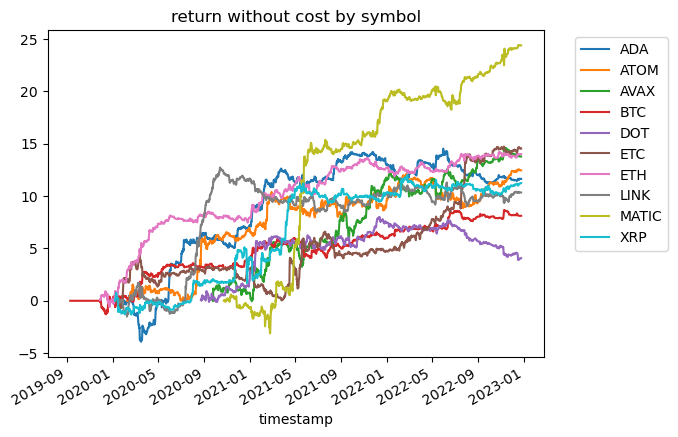

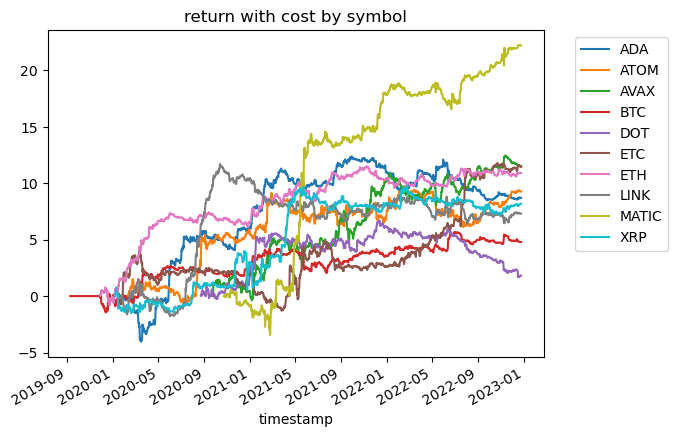

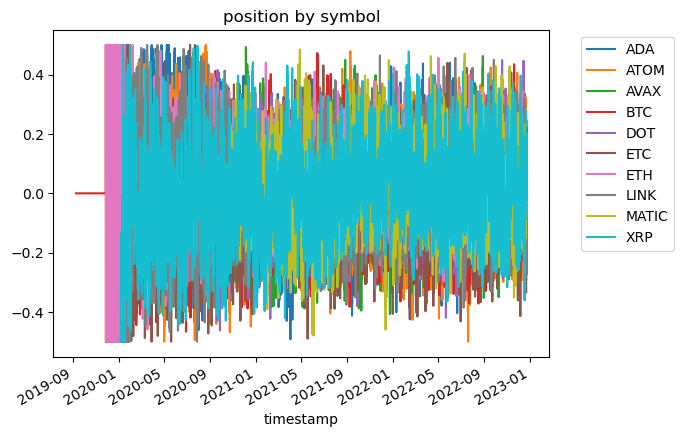

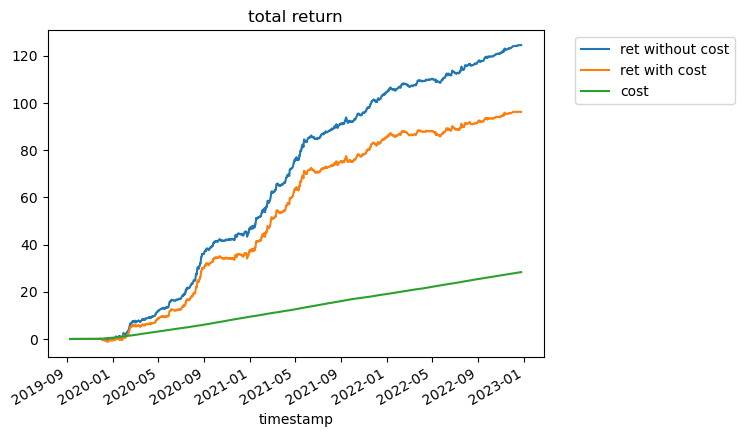

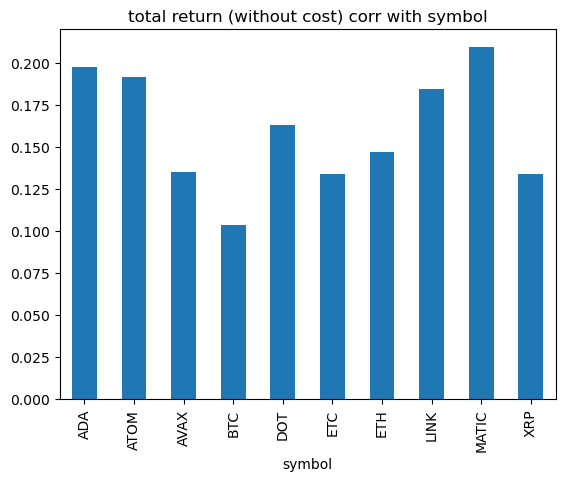

fit df.shape (243041, 776)
model size 13496536
0.0


In [9]:
df = pd.read_pickle('/tmp/df_binance_ohlcv_with_spot.pkl')
# df = df.loc[df.index.get_level_values('timestamp') < pd.to_datetime('2022-11-22 00:00:00Z')]
df = df.loc[df.index.get_level_values('timestamp') < pd.to_datetime('2022-12-25 00:00:00Z')]
# df = df.loc[df.index.get_level_values('timestamp') >= pd.to_datetime('2018-01-01 00:00:00Z')]

horizon = 24

df['ret'] = df.groupby('symbol')['twap_5m'].transform(lambda x: x.shift(-horizon - 1) / x.shift(-1) - 1).fillna(0)
df['execution_start_at'] = df.index.get_level_values('timestamp')

model = ExampleModelRank()

# cv
df_cv = calc_position_cv2(model, df)
visualize_result(df_cv.dropna(), horizon=horizon)
if 'extended' in df.columns and df['extended'].any():
    visualize_result(df_cv.loc[~df['extended']].dropna(), horizon=horizon)

# fit and save model as portable format
model.fit(df)
data = cloudpickle.dumps(model)
data = lzma.compress(data)
with open('/home/jovyan/data/{}.xz'.format(model_name), 'wb') as f:
    f.write(data)
print('model size {}'.format(os.path.getsize('/home/jovyan/data/{}.xz'.format(model_name))))

# validate cloudpickle
res1 = model.predict(df.iloc[-2 * 24 * 30 * 30:])
res2 = joblib.load('/home/jovyan/data/{}.xz'.format(model_name)).predict(df.iloc[-2 * 24 * 30 * 30:])
print((res1 - res2).abs().mean())

expt

- [20221104_btc_one_h12/20221108_224508.ipynb](20221104_btc_one_h12/20221108_224508.ipynb) without hedge
- [20221104_btc_one_h12/20221108_224536.ipynb](20221104_btc_one_h12/20221108_224536.ipynb) with hedge
- [20221104_btc_one_h12/20221109_005418.ipynb](20221104_btc_one_h12/20221109_005418.ipynb) with hedge, lgbm 100 * bagging 100, subsample 0.5
- [20221104_btc_one_h12/20221109_112941.ipynb](20221104_btc_one_h12/20221109_112941.ipynb) with hedge, subsample 0.5
- [20221104_btc_one_h12/20221109_113019.ipynb](20221104_btc_one_h12/20221109_113019.ipynb) with hedge, subsample 0.5, l2 1e1
- [20221104_btc_one_h12/20221109_113046.ipynb](20221104_btc_one_h12/20221109_113046.ipynb) with hedge l2 1e1
- these are evaluated with horizon 4 (wrong setting)
- the latest version is evaluated with horizon 12
- current: with hedge, subsample 0.5 <- new baseline

- [20221104_btc_one_h12/20221110_013653.ipynb](20221104_btc_one_h12/20221110_013653.ipynb) new baseline <- good
- [20221104_btc_one_h12/20221109_215052.ipynb](20221104_btc_one_h12/20221109_215052.ipynb) y shrink
- [20221104_btc_one_h12/20221109_221350.ipynb](20221104_btc_one_h12/20221109_221350.ipynb) y^0.5, y^0.5
- [20221104_btc_one_h12/20221109_220049.ipynb](20221104_btc_one_h12/20221109_220049.ipynb) 1/y, y^2
- [20221104_btc_one_h12/20221109_220641.ipynb](20221104_btc_one_h12/20221109_220641.ipynb) 1/y^2, y^3
- [20221104_btc_one_h12/20221110_013729.ipynb](20221104_btc_one_h12/20221110_013729.ipynb) y timestamp normalized
- [20221104_btc_one_h12/20221110_014924.ipynb](20221104_btc_one_h12/20221110_014924.ipynb) y timestamp normalized, y raw

expt2

- [20221104_btc_one_h12/20221122_162656.ipynb](20221104_btc_one_h12/20221122_162656.ipynb) (evaluated with horizon 24)
- [20221104_btc_one_h12/20221123_130232.ipynb](20221104_btc_one_h12/20221123_130232.ipynb)
- [20221104_btc_one_h12/20221123_130343.ipynb](20221104_btc_one_h12/20221123_130343.ipynb) 2018
- [20221104_btc_one_h12/20221123_130245.ipynb](20221104_btc_one_h12/20221123_130245.ipynb) -ltc
- [20221104_btc_one_h12/20221123_130350.ipynb](20221104_btc_one_h12/20221123_130350.ipynb) -ltc 2018
- [20221104_btc_one_h12/20221123_130257.ipynb](20221104_btc_one_h12/20221123_130257.ipynb) -ltc+avax selected
- [20221104_btc_one_h12/20221123_130358.ipynb](20221104_btc_one_h12/20221123_130358.ipynb) -ltc+avax 2018

expt3

- https://gist.github.com/richmanbtc/624422a38b3d4a1a2df5f902b4e99710 optuna + bbccv
- [20221224_beta_one/20221226_033154.ipynb](20221224_beta_one/20221226_033154.ipynb) 3 natfr
- [20221224_beta_one/20221226_044033.ipynb](20221224_beta_one/20221226_044033.ipynb) 3 natfr + no bagging
- [20221224_beta_one/20221226_044104.ipynb](20221224_beta_one/20221226_044104.ipynb) 2 natfr + no bagging
- [20221224_beta_one/20221226_044128.ipynb](20221224_beta_one/20221226_044128.ipynb) 1 natfr + no bagging
- [20221224_beta_one/20221226_044151.ipynb](20221224_beta_one/20221226_044151.ipynb) 0 natfr + no bagging

expt4 (pips upgraded)

- [20221224_beta_one/20221226_093031.ipynb](20221224_beta_one/20221226_093031.ipynb) 3 natfr
- [20221224_beta_one/20221226_093059.ipynb](20221224_beta_one/20221226_093059.ipynb) 2 natfr
- [20221224_beta_one/20221226_093123.ipynb](20221224_beta_one/20221226_093123.ipynb) 1 natfr
- [20221224_beta_one/20221226_093142.ipynb](20221224_beta_one/20221226_093142.ipynb) 0 natfr
- [20221224_beta_one/20221226_093634.ipynb](20221224_beta_one/20221226_093634.ipynb) 3 natfr + extra_trees=False
- [20221224_beta_one/20221226_093724.ipynb](20221224_beta_one/20221226_093724.ipynb) 0 natfr + extra_trees=False
- [20221224_beta_one/20221226_201443.ipynb](20221224_beta_one/20221226_201443.ipynb) 3 natfr + ens(extra_trees=False, extra_trees=True)
- [20221224_beta_one/20221226_201535.ipynb](20221224_beta_one/20221226_201535.ipynb) 2 natfr + ens(extra_trees=False, extra_trees=True) selected

timestamp                  symbol
2022-10-27 13:00:00+00:00  ADA       0.109840
                           ATOM     -0.039612
                           AVAX     -0.057758
                           BTC      -0.084935
                           DOT       0.230584
                                       ...   
2022-12-26 13:00:00+00:00  ADA       0.301556
                           BTC      -0.099666
                           ETH      -0.136189
                           LINK     -0.264144
                           MATIC     0.198444
Name: position, Length: 14405, dtype: float64
['ADA', 'ATOM', 'AVAX', 'BTC', 'DOT', 'ETC', 'ETH', 'LINK', 'MATIC', 'XRP']
test shift predict


position1  position2  position3
timestamp                 symbol                                 
2022-10-27 14:00:00+00:00 ADA      0.169660   0.169660   0.088289
                          ATOM    -0.064474  -0.064474  -0.106287
                          AVAX    -0.092689  -0.092689  -0.016414
                          BTC     -0.010194  -0.010194  -0.123520
                          DOT     -0.146069  -0.146069   0.110939
...                                     ...        ...        ...
2022-12-26 12:00:00+00:00 ETC     -0.135865  -0.135865  -0.135926
                          ETH     -0.067698  -0.067698  -0.067667
                          LINK    -0.127813  -0.127813  -0.127851
                          MATIC    0.120795   0.120795   0.120876
                          XRP      0.177145   0.177145   0.177643

[14390 rows x 3 columns]

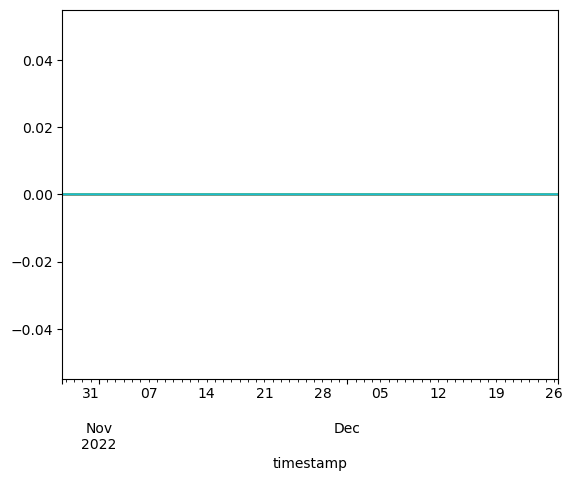

ADA (1439, 4)
ATOM (1439, 4)
AVAX (1439, 4)
BTC (1439, 4)
DOT (1439, 4)
ETC (1439, 4)
ETH (1439, 4)
LINK (1439, 4)
MATIC (1439, 4)
XRP (1439, 4)


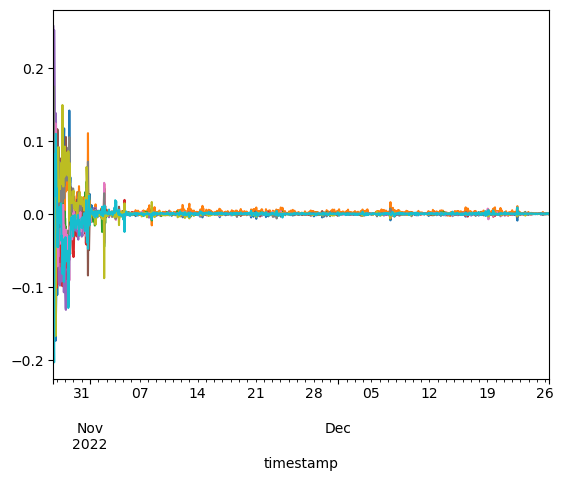

In [10]:
# model validation (Just run this cell in the new kernel to make sure you saved it in a portable format.)

import os
import joblib
import pandas as pd

model = joblib.load('/home/jovyan/data/{}.xz'.format(model_name))
df = pd.read_pickle('/tmp/df_binance_ohlcv_with_spot.pkl')
# df = df[['op', 'hi', 'lo', 'cl', 'volume']]
max_timestamp = df.index.get_level_values('timestamp').max()
df = df.loc[max_timestamp - pd.to_timedelta(model.max_data_sec, unit='S') <= df.index.get_level_values('timestamp')]
print(model.predict(df))
print(model.symbols)



print('test shift predict')
import matplotlib.pyplot as plt

position1 = model.predict(df)
position2 = model.predict(df.loc[df.index.get_level_values('timestamp') < max_timestamp])
position3 = model.predict(df.loc[df.index.get_level_values('timestamp').min() < df.index.get_level_values('timestamp')])

test_timestamp = max_timestamp - pd.to_timedelta(1, unit='H')
df_test = pd.concat([
    position1.rename('position1'),
    position2.rename('position2'),
    position3.rename('position3'),
], axis=1)

df_test = df_test.dropna()
display(df_test)

for symbol, df_symbol in df_test.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    (df_symbol['position2'] - df_symbol['position1']).plot()
plt.show()

for symbol, df_symbol in df_test.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    print(symbol, df_symbol.shape)
    (df_symbol['position3'] - df_symbol['position1']).plot()
plt.show()